Reached the target at step 415: x=19.97, y=29.91, theta=1.21


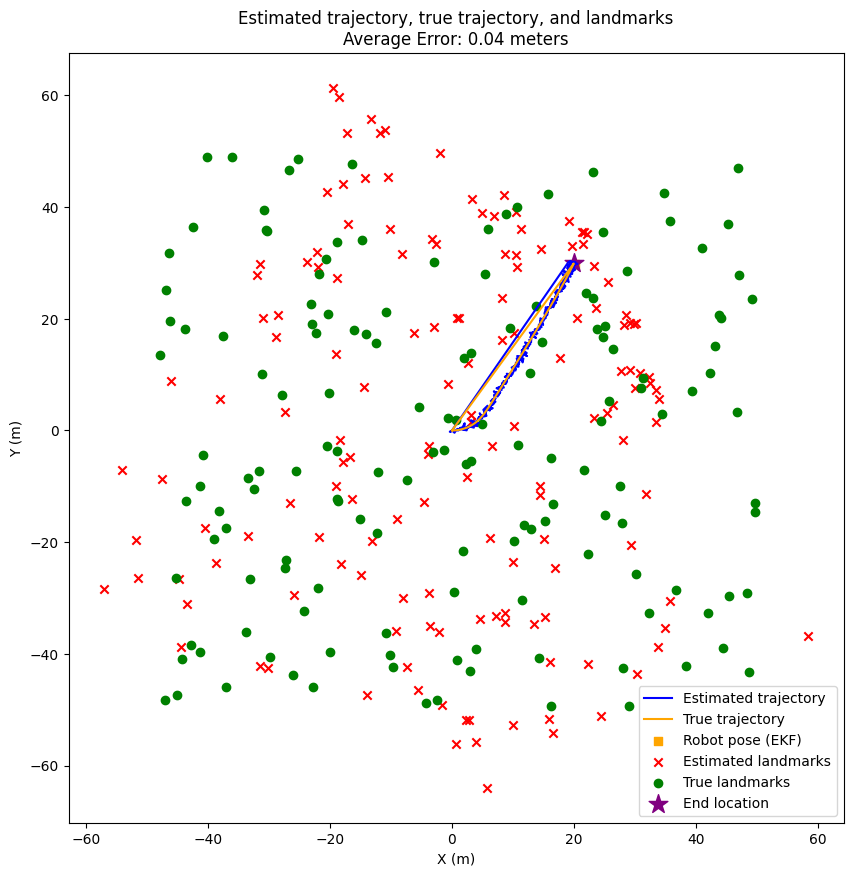

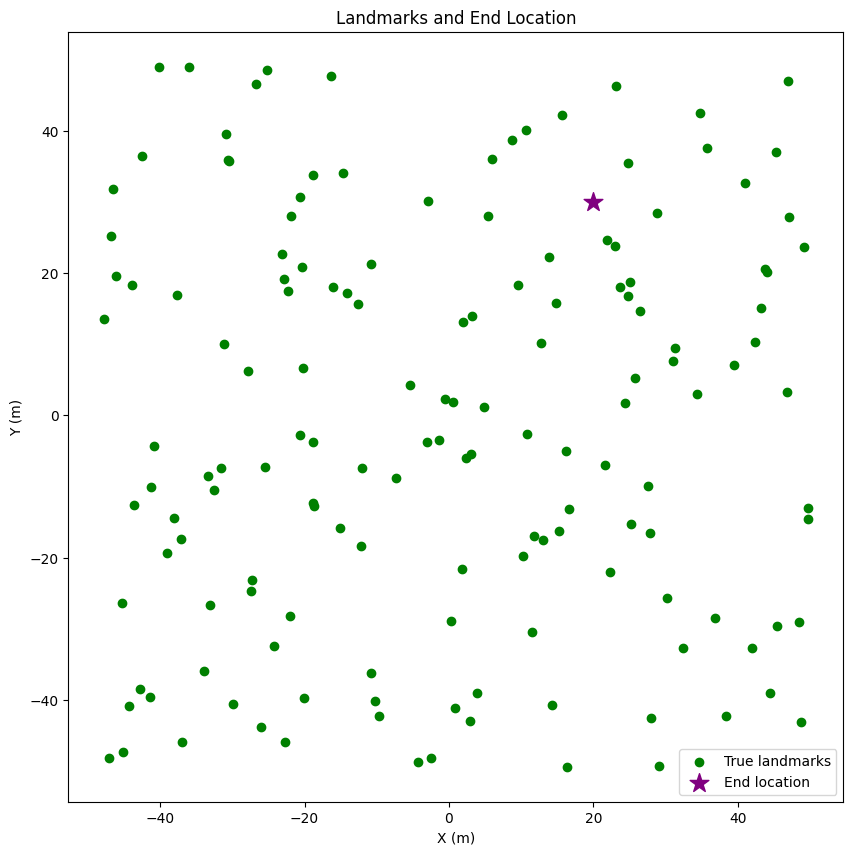

RMSE for the robot trajectory: 0.10 meters
RMSE for the landmarks: 46.85 meters


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# Seed for reproducibility
np.random.seed(677)

# Constants
ODOM_NOISE_LEVEL = 0.005
SIGMA_D_BASE, SIGMA_ALPHA_BASE = 0.01, 0.005
GPS_NOISE_LEVEL = 0.3
IMU_NOISE_LEVEL = 0.01
L = 0.25
DT, T = 0.1, 400
N_STEPS = int(T / DT)
N_LANDMARKS = 150
ENV_SIZE = 50
END_LOCATION = (20, 30)
WINDOW_SIZE = 10

# PID controller parameters for angular velocity
Kp = 0.7
Ki = 0.0
Kd = 0.03
integral = 0
prev_error = 0
dead_zone = 0.03
max_w = 0.2
integral_limit = 0.5  # Limit for the integral term

def generate_landmarks(distribution='uniform', nlandmarks=100, env_size=50):
    if distribution == 'uniform':
        return np.array([[random.uniform(-env_size, env_size), random.uniform(-env_size, env_size)] for _ in range(nlandmarks)])
    else:
        raise ValueError("Invalid distribution type")

def normalize_angle(angle):
    return ((angle + np.pi) % (2 * np.pi)) - np.pi

def calculate_motion_commands(x, y, theta, target_x, target_y):
    global integral, prev_error

    dx = target_x - x
    dy = target_y - y
    distance = math.hypot(dx, dy)
    angle_to_target = math.atan2(dy, dx)
    angle_diff = normalize_angle(angle_to_target - theta)

    # Dynamic linear velocity adjustment
    if distance < 0.1:
        v = 0
    elif distance < 1.0:
        v = min(0.5, distance * 0.5)
    elif distance < 5.0:
        v = min(0.5, distance * 0.2)
    elif distance < 10.0:
        v = min(1.0, distance * 0.3)
    else:
        v = min(1.2, distance * 0.8)

    # PID control for angular velocity
    error = angle_diff
    integral += error * DT
    integral = max(min(integral, integral_limit), -integral_limit)
    derivative = (error - prev_error) / DT

    if abs(error) < dead_zone:
        w = 0
    else:
        w = Kp * error + Kd * derivative

    prev_error = error

    # Limit angular velocity
    w = max(min(w, max_w), -max_w)

    return v, w

def motion_model(x, y, theta, v, w, dt):
    if abs(w) < 1e-6:
        x += v * dt * math.cos(theta)
        y += v * dt * math.sin(theta)
    else:
        x += v / w * (math.sin(theta + w * dt) - math.sin(theta))
        y -= v / w * (math.cos(theta + w * dt) - math.cos(theta))
    theta += w * dt
    theta = normalize_angle(theta)
    return x, y, theta

def measurement_model(x, y, theta, landmarks, sigma_d, sigma_alpha):
    d, alpha = np.zeros(len(landmarks)), np.zeros(len(landmarks))
    for i, landmark in enumerate(landmarks):
        dx, dy = landmark - [x, y]
        d[i] = math.hypot(dx, dy) + np.random.normal(0, sigma_d)
        alpha[i] = math.atan2(dy, dx) - theta + np.random.normal(0, sigma_alpha)
        alpha[i] = normalize_angle(alpha[i])
    return d, alpha

def gps_model(x, y, noise_level):
    return x + np.random.normal(0, noise_level), y + np.random.normal(0, noise_level)

def imu_model(v, w, noise_level):
    return v + np.random.normal(0, noise_level), w + np.random.normal(0, noise_level)

def initialize_ekf_slam(nlandmarks):
    mu = np.zeros(3 + 2 * nlandmarks)
    Sigma = np.eye(3 + 2 * nlandmarks) * 1e-2
    return mu, Sigma

def adaptive_noise(v, w, base_d, base_alpha):
    sigma_d = base_d + 0.05 * abs(v)
    sigma_alpha = base_alpha + 0.02 * abs(w)
    return sigma_d, sigma_alpha

def prediction(mu, Sigma, v, w, dt):
    theta = mu[2]
    if abs(w) < 1e-6:
        mu[:3] += np.array([v * dt * math.cos(theta), v * dt * math.sin(theta), w * dt])
    else:
        mu[:3] += np.array([v/w * (math.sin(theta + w*dt) - math.sin(theta)),
                            -v/w * (math.cos(theta + w*dt) - math.cos(theta)),
                            w*dt])
    mu[2] = normalize_angle(mu[2])

    G_pose = np.eye(3)
    if abs(w) < 1e-6:
        G_pose[0, 2] = -v * dt * math.sin(theta)
        G_pose[1, 2] = v * dt * math.cos(theta)
    else:
        G_pose[0, 2] = v/w * (math.cos(theta + w*dt) - math.cos(theta))
        G_pose[1, 2] = v/w * (math.sin(theta + w*dt) - math.sin(theta))

    R_pose = np.diag([ODOM_NOISE_LEVEL * abs(v), ODOM_NOISE_LEVEL * abs(w), 0.01])
    Sigma[:3, :3] = G_pose @ Sigma[:3, :3] @ G_pose.T + R_pose
    return mu, Sigma

def measurement_update(mu, Sigma, z, R):
    for i in range(len(z)):
        if i >= N_LANDMARKS:
            continue
        dx = mu[3 + i*2] - mu[0]
        dy = mu[3 + i*2 + 1] - mu[1]
        q = dx**2 + dy**2

        if q < 1e-6:
            continue

        sqrt_q = math.sqrt(q)
        z_hat = np.array([sqrt_q, math.atan2(dy, dx) - mu[2]])
        z_hat[1] = normalize_angle(z_hat[1])

        H = np.zeros((2, 3 + 2 * N_LANDMARKS))
        H[:, :3] = np.array([[-dx / sqrt_q, -dy / sqrt_q, 0],
                             [dy / q, -dx / q, -1]])
        H[:, 3 + i*2:3 + i*2 + 2] = np.array([[dx / sqrt_q, dy / sqrt_q],
                                              [-dy / q, dx / q]])

        S = H @ Sigma @ H.T + R
        K = Sigma @ H.T @ np.linalg.inv(S)

        z_diff = z[i] - z_hat
        z_diff[1] = normalize_angle(z_diff[1])
        mu += K @ z_diff
        Sigma = (np.eye(len(mu)) - K @ H) @ Sigma

    return mu, Sigma

def calculate_rmse(estimates, ground_truths):
    return np.sqrt(np.mean((estimates - ground_truths) ** 2))

# Main Simulation
def main():
    x, y, theta = 0, 0, 0
    landmarks = generate_landmarks(distribution='uniform', nlandmarks=N_LANDMARKS, env_size=ENV_SIZE)
    mu, Sigma = initialize_ekf_slam(N_LANDMARKS)

    traj_x, traj_y, traj_ori = np.zeros(N_STEPS), np.zeros(N_STEPS), np.zeros(N_STEPS)
    x_true, y_true = np.zeros(N_STEPS), np.zeros(N_STEPS)
    v_true, w_true = np.zeros(N_STEPS), np.zeros(N_STEPS)
    v_noisy, w_noisy = np.zeros(N_STEPS), np.zeros(N_STEPS)
    d_true, d_noisy = np.zeros((N_STEPS, N_LANDMARKS)), np.zeros((N_STEPS, N_LANDMARKS))
    alpha_true, alpha_noisy = np.zeros((N_STEPS, N_LANDMARKS)), np.zeros((N_STEPS, N_LANDMARKS))
    gps_x, gps_y = np.zeros(N_STEPS), np.zeros(N_STEPS)
    imu_acc, imu_ang_vel = np.zeros(N_STEPS), np.zeros(N_STEPS)
    v, w = np.zeros(N_STEPS), np.zeros(N_STEPS)

    for i in range(N_STEPS):
        traj_x[i], traj_y[i], traj_ori[i] = mu[0], mu[1], mu[2]
        v[i], w[i] = calculate_motion_commands(x, y, theta, END_LOCATION[0], END_LOCATION[1])
        x, y, theta = motion_model(x, y, theta, v[i], w[i], DT)
        x_true[i], y_true[i] = x, y
        v_true[i], w_true[i] = v[i], w[i]
        sigma_v = np.abs(v[i]) * ODOM_NOISE_LEVEL
        sigma_w = np.abs(w[i]) * ODOM_NOISE_LEVEL
        v_noisy[i], w_noisy[i] = v[i] + np.random.normal(0, sigma_v), w[i] + np.random.normal(0, sigma_w)

        sigma_d, sigma_alpha = adaptive_noise(v[i], w[i], SIGMA_D_BASE, SIGMA_ALPHA_BASE)
        d_true[i], alpha_true[i] = measurement_model(x, y, theta, landmarks, sigma_d, sigma_alpha)
        d_noisy[i] = d_true[i] + np.random.normal(0, sigma_d, N_LANDMARKS)
        alpha_noisy[i] = alpha_true[i] + np.random.normal(0, sigma_alpha, N_LANDMARKS)

        gps_x[i], gps_y[i] = gps_model(x, y, GPS_NOISE_LEVEL)
        imu_acc[i], imu_ang_vel[i] = imu_model(v[i], w[i], IMU_NOISE_LEVEL)

        mu, Sigma = prediction(mu, Sigma, v_noisy[i], w_noisy[i], DT)

        z = np.vstack((d_noisy[i], alpha_noisy[i])).T
        R = np.diag([sigma_d, sigma_alpha])**2
        mu, Sigma = measurement_update(mu, Sigma, z, R)

        gps_pos = np.array([gps_x[i], gps_y[i]])
        gps_cov = np.diag([GPS_NOISE_LEVEL, GPS_NOISE_LEVEL])
        mu[:2], Sigma[:2, :2] = gps_pos, gps_cov

        distance_to_target = math.hypot(x - END_LOCATION[0], y - END_LOCATION[1])
        if distance_to_target < 0.1:
            print(f"Reached the target at step {i}: x={x:.2f}, y={y:.2f}, theta={theta:.2f}")
            break

    error = np.sqrt((traj_x - x_true)**2 + (traj_y - y_true)**2)
    average_error = np.mean(error)

    # RMSE for the robot trajectory
    rmse_robot = calculate_rmse(np.vstack((traj_x, traj_y)).T, np.vstack((x_true, y_true)).T)

    # RMSE for the landmarks
    estimated_landmarks = mu[3:].reshape(N_LANDMARKS, 2)
    rmse_landmarks = calculate_rmse(estimated_landmarks, landmarks)

    plt.figure(figsize=(10, 10))
    plt.plot(traj_x, traj_y, label='Estimated trajectory', color='blue')
    plt.plot(x_true, y_true, label='True trajectory', color='orange')
    plt.scatter(mu[0], mu[1], c='orange', marker='s', label='Robot pose (EKF)')
    plt.scatter(mu[3::2], mu[4::2], c='r', marker='x', label='Estimated landmarks')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], c='g', marker='o', label='True landmarks')
    plt.scatter(*END_LOCATION, c='purple', marker='*', s=200, label='End location')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title(f'Estimated trajectory, true trajectory, and landmarks\nAverage Error: {average_error:.2f} meters')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.scatter(landmarks[:, 0], landmarks[:, 1], c='g', marker='o', label='True landmarks')
    plt.scatter(*END_LOCATION, c='purple', marker='*', s=200, label='End location')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Landmarks and End Location')
    plt.legend()
    plt.show()

    print(f"RMSE for the robot trajectory: {rmse_robot:.2f} meters")
    print(f"RMSE for the landmarks: {rmse_landmarks:.2f} meters")

if __name__ == "__main__":
    main()
